<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:09:25] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


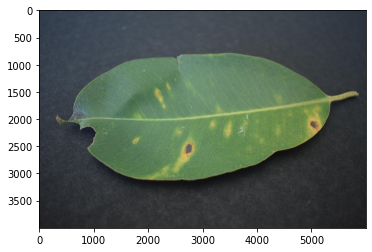

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

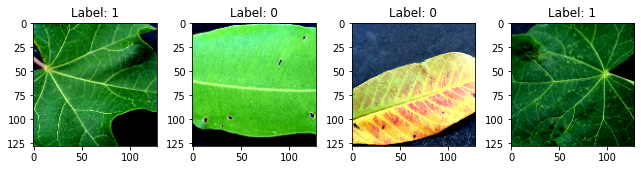

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:09:31] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:09:33] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.253088033884104 samples/sec                   batch loss = 0.3958100974559784 | accuracy = 0.75


Epoch[1] Batch[10] Speed: 1.2627429687678167 samples/sec                   batch loss = 0.8617164492607117 | accuracy = 0.675


Epoch[1] Batch[15] Speed: 1.2590022529974367 samples/sec                   batch loss = 0.5148845911026001 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2625398042588065 samples/sec                   batch loss = 0.942962646484375 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.261481138892947 samples/sec                   batch loss = 0.39758729934692383 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2234938719622162 samples/sec                   batch loss = 0.5360329747200012 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2638471669343811 samples/sec                   batch loss = 0.9743844866752625 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.260366582633293 samples/sec                   batch loss = 0.5123369097709656 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.262842959592481 samples/sec                   batch loss = 0.5909058451652527 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2602524047923378 samples/sec                   batch loss = 0.37404772639274597 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2556473090261147 samples/sec                   batch loss = 1.1303596496582031 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2593897341803821 samples/sec                   batch loss = 0.442261278629303 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.260643971359848 samples/sec                   batch loss = 0.44347822666168213 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.2621803879840048 samples/sec                   batch loss = 0.5614347457885742 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2655687582265247 samples/sec                   batch loss = 0.7027838230133057 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2623083068402732 samples/sec                   batch loss = 0.6952615976333618 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.2563453722874012 samples/sec                   batch loss = 0.7108142375946045 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.261216749903495 samples/sec                   batch loss = 0.49729350209236145 | accuracy = 0.6027777777777777


Epoch[1] Batch[95] Speed: 1.2652244083434507 samples/sec                   batch loss = 0.5585603713989258 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2603783234847745 samples/sec                   batch loss = 0.7190740704536438 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.2615860527543272 samples/sec                   batch loss = 0.6231645345687866 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.2609405306253838 samples/sec                   batch loss = 0.6257143020629883 | accuracy = 0.6204545454545455


Epoch[1] Batch[115] Speed: 1.2633777800335264 samples/sec                   batch loss = 0.28105971217155457 | accuracy = 0.6195652173913043


Epoch[1] Batch[120] Speed: 1.2650970425598593 samples/sec                   batch loss = 0.7284704446792603 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.2627268120408262 samples/sec                   batch loss = 0.4374229311943054 | accuracy = 0.61


Epoch[1] Batch[130] Speed: 1.2663202401667655 samples/sec                   batch loss = 0.5049573183059692 | accuracy = 0.6115384615384616


Epoch[1] Batch[135] Speed: 1.2625641273402608 samples/sec                   batch loss = 0.976898193359375 | accuracy = 0.6185185185185185


Epoch[1] Batch[140] Speed: 1.2703011029905866 samples/sec                   batch loss = 0.5831021070480347 | accuracy = 0.6214285714285714


Epoch[1] Batch[145] Speed: 1.266101781892495 samples/sec                   batch loss = 0.7801607847213745 | accuracy = 0.6258620689655172


Epoch[1] Batch[150] Speed: 1.2557211782505335 samples/sec                   batch loss = 0.6411543488502502 | accuracy = 0.6266666666666667


Epoch[1] Batch[155] Speed: 1.2556335887277783 samples/sec                   batch loss = 0.5593341588973999 | accuracy = 0.6258064516129033


Epoch[1] Batch[160] Speed: 1.2606578013740746 samples/sec                   batch loss = 0.531825065612793 | accuracy = 0.6265625


Epoch[1] Batch[165] Speed: 1.2593369849156986 samples/sec                   batch loss = 0.424939900636673 | accuracy = 0.6348484848484849


Epoch[1] Batch[170] Speed: 1.2628422942019597 samples/sec                   batch loss = 0.98508220911026 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.2551917863018793 samples/sec                   batch loss = 0.5281822085380554 | accuracy = 0.64


Epoch[1] Batch[180] Speed: 1.2614064007825325 samples/sec                   batch loss = 0.3175201714038849 | accuracy = 0.6402777777777777


Epoch[1] Batch[185] Speed: 1.26499545453483 samples/sec                   batch loss = 0.13186250627040863 | accuracy = 0.6445945945945946


Epoch[1] Batch[190] Speed: 1.2635297310886069 samples/sec                   batch loss = 0.8779596090316772 | accuracy = 0.6473684210526316


Epoch[1] Batch[195] Speed: 1.2653643971755517 samples/sec                   batch loss = 0.5878823399543762 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2620311346150968 samples/sec                   batch loss = 0.3101426959037781 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.263895248336361 samples/sec                   batch loss = 0.827072024345398 | accuracy = 0.6597560975609756


Epoch[1] Batch[210] Speed: 1.2628007562104844 samples/sec                   batch loss = 0.7422578930854797 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2665529247280007 samples/sec                   batch loss = 0.2712368667125702 | accuracy = 0.663953488372093


Epoch[1] Batch[220] Speed: 1.259238777179828 samples/sec                   batch loss = 0.3987884223461151 | accuracy = 0.6693181818181818


Epoch[1] Batch[225] Speed: 1.2603126154038462 samples/sec                   batch loss = 0.6837466955184937 | accuracy = 0.6677777777777778


Epoch[1] Batch[230] Speed: 1.2611112338856534 samples/sec                   batch loss = 0.7614866495132446 | accuracy = 0.6684782608695652


Epoch[1] Batch[235] Speed: 1.2613314818706138 samples/sec                   batch loss = 1.302004337310791 | accuracy = 0.6680851063829787


Epoch[1] Batch[240] Speed: 1.2563721857142354 samples/sec                   batch loss = 0.3800315856933594 | accuracy = 0.6666666666666666


Epoch[1] Batch[245] Speed: 1.2601085285198312 samples/sec                   batch loss = 0.37199607491493225 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.2589025860409109 samples/sec                   batch loss = 0.7632872462272644 | accuracy = 0.666


Epoch[1] Batch[255] Speed: 1.2547235504248109 samples/sec                   batch loss = 0.573821485042572 | accuracy = 0.6656862745098039


Epoch[1] Batch[260] Speed: 1.257946962813626 samples/sec                   batch loss = 0.43991246819496155 | accuracy = 0.6673076923076923


Epoch[1] Batch[265] Speed: 1.2575809182973456 samples/sec                   batch loss = 0.7017879486083984 | accuracy = 0.6641509433962264


Epoch[1] Batch[270] Speed: 1.2596334969451821 samples/sec                   batch loss = 0.46220454573631287 | accuracy = 0.6657407407407407


Epoch[1] Batch[275] Speed: 1.2575755451966173 samples/sec                   batch loss = 0.8945311307907104 | accuracy = 0.6663636363636364


Epoch[1] Batch[280] Speed: 1.2566240055162814 samples/sec                   batch loss = 0.8292021155357361 | accuracy = 0.6669642857142857


Epoch[1] Batch[285] Speed: 1.2609844105039543 samples/sec                   batch loss = 0.5373162627220154 | accuracy = 0.6675438596491228


Epoch[1] Batch[290] Speed: 1.2589040029960583 samples/sec                   batch loss = 0.4994981586933136 | accuracy = 0.6698275862068965


Epoch[1] Batch[295] Speed: 1.2571362375101935 samples/sec                   batch loss = 0.7847662568092346 | accuracy = 0.6686440677966101


Epoch[1] Batch[300] Speed: 1.261174844753157 samples/sec                   batch loss = 0.6420828104019165 | accuracy = 0.6675


Epoch[1] Batch[305] Speed: 1.2639237180590654 samples/sec                   batch loss = 0.2869148552417755 | accuracy = 0.6680327868852459


Epoch[1] Batch[310] Speed: 1.2614403543085224 samples/sec                   batch loss = 0.7156454920768738 | accuracy = 0.667741935483871


Epoch[1] Batch[315] Speed: 1.2618233590377865 samples/sec                   batch loss = 0.2420242577791214 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2621770645285642 samples/sec                   batch loss = 0.6618739366531372 | accuracy = 0.66796875


Epoch[1] Batch[325] Speed: 1.2566237231505653 samples/sec                   batch loss = 0.714907169342041 | accuracy = 0.6684615384615384


Epoch[1] Batch[330] Speed: 1.2622565473872032 samples/sec                   batch loss = 0.46992814540863037 | accuracy = 0.6712121212121213


Epoch[1] Batch[335] Speed: 1.254671848119729 samples/sec                   batch loss = 0.6767849326133728 | accuracy = 0.6723880597014925


Epoch[1] Batch[340] Speed: 1.2640238959748171 samples/sec                   batch loss = 0.40339183807373047 | accuracy = 0.6757352941176471


Epoch[1] Batch[345] Speed: 1.2559382311224478 samples/sec                   batch loss = 0.2751719653606415 | accuracy = 0.6760869565217391


Epoch[1] Batch[350] Speed: 1.2589850581401676 samples/sec                   batch loss = 0.7989102602005005 | accuracy = 0.6771428571428572


Epoch[1] Batch[355] Speed: 1.2672322521978006 samples/sec                   batch loss = 0.6892974972724915 | accuracy = 0.678169014084507


Epoch[1] Batch[360] Speed: 1.2708358109149127 samples/sec                   batch loss = 0.7117429375648499 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.2598706368238541 samples/sec                   batch loss = 0.3864224851131439 | accuracy = 0.6760273972602739


Epoch[1] Batch[370] Speed: 1.2641839088497235 samples/sec                   batch loss = 0.7748842835426331 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2625481652123507 samples/sec                   batch loss = 0.41685962677001953 | accuracy = 0.676


Epoch[1] Batch[380] Speed: 1.2661215604436025 samples/sec                   batch loss = 1.141929030418396 | accuracy = 0.6756578947368421


Epoch[1] Batch[385] Speed: 1.2647296858849029 samples/sec                   batch loss = 0.7372220158576965 | accuracy = 0.6753246753246753


Epoch[1] Batch[390] Speed: 1.2589160944763957 samples/sec                   batch loss = 0.646565318107605 | accuracy = 0.6756410256410257


Epoch[1] Batch[395] Speed: 1.2626643749293491 samples/sec                   batch loss = 0.6077297329902649 | accuracy = 0.6746835443037975


Epoch[1] Batch[400] Speed: 1.2597411305477322 samples/sec                   batch loss = 0.25537925958633423 | accuracy = 0.67625


Epoch[1] Batch[405] Speed: 1.2577877704448794 samples/sec                   batch loss = 0.49379798769950867 | accuracy = 0.6746913580246914


Epoch[1] Batch[410] Speed: 1.2641614284049054 samples/sec                   batch loss = 0.3521418273448944 | accuracy = 0.675


Epoch[1] Batch[415] Speed: 1.257652375475877 samples/sec                   batch loss = 0.3652448356151581 | accuracy = 0.6765060240963855


Epoch[1] Batch[420] Speed: 1.2574987243039437 samples/sec                   batch loss = 0.4406796395778656 | accuracy = 0.6785714285714286


Epoch[1] Batch[425] Speed: 1.2608777014729164 samples/sec                   batch loss = 0.7852144837379456 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2595344864916158 samples/sec                   batch loss = 0.4788283109664917 | accuracy = 0.6767441860465117


Epoch[1] Batch[435] Speed: 1.2598246585744168 samples/sec                   batch loss = 0.8826287984848022 | accuracy = 0.6758620689655173


Epoch[1] Batch[440] Speed: 1.2663526426288951 samples/sec                   batch loss = 0.7970955967903137 | accuracy = 0.6761363636363636


Epoch[1] Batch[445] Speed: 1.2630419428115944 samples/sec                   batch loss = 0.5061078071594238 | accuracy = 0.6758426966292135


Epoch[1] Batch[450] Speed: 1.2637178889516836 samples/sec                   batch loss = 0.4297448694705963 | accuracy = 0.6761111111111111


Epoch[1] Batch[455] Speed: 1.2585754492652166 samples/sec                   batch loss = 0.45723119378089905 | accuracy = 0.6763736263736264


Epoch[1] Batch[460] Speed: 1.2565482419336138 samples/sec                   batch loss = 0.6230762600898743 | accuracy = 0.6760869565217391


Epoch[1] Batch[465] Speed: 1.2599002501069179 samples/sec                   batch loss = 0.44025108218193054 | accuracy = 0.6752688172043011


Epoch[1] Batch[470] Speed: 1.2585162541691517 samples/sec                   batch loss = 0.5687493085861206 | accuracy = 0.676063829787234


Epoch[1] Batch[475] Speed: 1.2628013265076552 samples/sec                   batch loss = 0.4187838137149811 | accuracy = 0.6757894736842105


Epoch[1] Batch[480] Speed: 1.2565464538351885 samples/sec                   batch loss = 0.8477346301078796 | accuracy = 0.6760416666666667


Epoch[1] Batch[485] Speed: 1.2594379497391863 samples/sec                   batch loss = 0.7686733603477478 | accuracy = 0.6757731958762887


Epoch[1] Batch[490] Speed: 1.2514671374197208 samples/sec                   batch loss = 0.19320756196975708 | accuracy = 0.6780612244897959


Epoch[1] Batch[495] Speed: 1.2563161140292318 samples/sec                   batch loss = 0.769599199295044 | accuracy = 0.6782828282828283


Epoch[1] Batch[500] Speed: 1.2581967723322365 samples/sec                   batch loss = 0.7086113095283508 | accuracy = 0.6785


Epoch[1] Batch[505] Speed: 1.257936681994597 samples/sec                   batch loss = 0.5026019215583801 | accuracy = 0.6787128712871288


Epoch[1] Batch[510] Speed: 1.2629405894861343 samples/sec                   batch loss = 1.4832907915115356 | accuracy = 0.678921568627451


Epoch[1] Batch[515] Speed: 1.26030276925 samples/sec                   batch loss = 0.25649014115333557 | accuracy = 0.6800970873786408


Epoch[1] Batch[520] Speed: 1.2600747412906914 samples/sec                   batch loss = 0.4818977117538452 | accuracy = 0.68125


Epoch[1] Batch[525] Speed: 1.2636572573605185 samples/sec                   batch loss = 0.33702391386032104 | accuracy = 0.6814285714285714


Epoch[1] Batch[530] Speed: 1.260797349932328 samples/sec                   batch loss = 0.39764702320098877 | accuracy = 0.6825471698113208


Epoch[1] Batch[535] Speed: 1.2661252869064694 samples/sec                   batch loss = 0.7765701413154602 | accuracy = 0.6822429906542056


Epoch[1] Batch[540] Speed: 1.260901960554426 samples/sec                   batch loss = 0.6249481439590454 | accuracy = 0.6828703703703703


Epoch[1] Batch[545] Speed: 1.265301221829178 samples/sec                   batch loss = 0.897537887096405 | accuracy = 0.6844036697247706


Epoch[1] Batch[550] Speed: 1.2648223632370472 samples/sec                   batch loss = 0.6548919081687927 | accuracy = 0.685


Epoch[1] Batch[555] Speed: 1.2554153259566816 samples/sec                   batch loss = 0.441856324672699 | accuracy = 0.6851351351351351


Epoch[1] Batch[560] Speed: 1.2622981445577233 samples/sec                   batch loss = 0.9256482124328613 | accuracy = 0.6857142857142857


Epoch[1] Batch[565] Speed: 1.2583821181080332 samples/sec                   batch loss = 0.7185072898864746 | accuracy = 0.6845132743362832


Epoch[1] Batch[570] Speed: 1.2656488597991131 samples/sec                   batch loss = 0.15603238344192505 | accuracy = 0.6850877192982456


Epoch[1] Batch[575] Speed: 1.2594016459162456 samples/sec                   batch loss = 0.354495108127594 | accuracy = 0.6869565217391305


Epoch[1] Batch[580] Speed: 1.2651328168754192 samples/sec                   batch loss = 1.0539491176605225 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.2623574110155575 samples/sec                   batch loss = 0.25735607743263245 | accuracy = 0.6867521367521368


Epoch[1] Batch[590] Speed: 1.2559558129635848 samples/sec                   batch loss = 1.1247631311416626 | accuracy = 0.6872881355932203


Epoch[1] Batch[595] Speed: 1.255994363108184 samples/sec                   batch loss = 1.1087578535079956 | accuracy = 0.6882352941176471


Epoch[1] Batch[600] Speed: 1.2582919864324915 samples/sec                   batch loss = 0.592924177646637 | accuracy = 0.6883333333333334


Epoch[1] Batch[605] Speed: 1.2612077429054689 samples/sec                   batch loss = 0.7080603241920471 | accuracy = 0.6867768595041323


Epoch[1] Batch[610] Speed: 1.2595052686160508 samples/sec                   batch loss = 0.9213825464248657 | accuracy = 0.6856557377049181


Epoch[1] Batch[615] Speed: 1.2574889220677208 samples/sec                   batch loss = 0.573986291885376 | accuracy = 0.6857723577235773


Epoch[1] Batch[620] Speed: 1.2588374095520045 samples/sec                   batch loss = 0.9371235966682434 | accuracy = 0.6850806451612903


Epoch[1] Batch[625] Speed: 1.2584685811465126 samples/sec                   batch loss = 0.2880270183086395 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.262393505495295 samples/sec                   batch loss = 0.4513048231601715 | accuracy = 0.6865079365079365


Epoch[1] Batch[635] Speed: 1.2592969059915475 samples/sec                   batch loss = 0.5864754319190979 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.2604871261346173 samples/sec                   batch loss = 0.3081343472003937 | accuracy = 0.68671875


Epoch[1] Batch[645] Speed: 1.2563347413157175 samples/sec                   batch loss = 0.5017643570899963 | accuracy = 0.6875968992248062


Epoch[1] Batch[650] Speed: 1.254048659331831 samples/sec                   batch loss = 0.3751365840435028 | accuracy = 0.686923076923077


Epoch[1] Batch[655] Speed: 1.2574074940132076 samples/sec                   batch loss = 0.5792554616928101 | accuracy = 0.6870229007633588


Epoch[1] Batch[660] Speed: 1.255541595294844 samples/sec                   batch loss = 0.5780129432678223 | accuracy = 0.6856060606060606


Epoch[1] Batch[665] Speed: 1.2587617566136662 samples/sec                   batch loss = 1.374400019645691 | accuracy = 0.6857142857142857


Epoch[1] Batch[670] Speed: 1.2560188107675594 samples/sec                   batch loss = 0.6265548467636108 | accuracy = 0.685820895522388


Epoch[1] Batch[675] Speed: 1.2546591812356793 samples/sec                   batch loss = 0.4026400148868561 | accuracy = 0.6866666666666666


Epoch[1] Batch[680] Speed: 1.2665631556335215 samples/sec                   batch loss = 0.9071366190910339 | accuracy = 0.6856617647058824


Epoch[1] Batch[685] Speed: 1.258310577982901 samples/sec                   batch loss = 0.23553386330604553 | accuracy = 0.6857664233576642


Epoch[1] Batch[690] Speed: 1.2617712597672825 samples/sec                   batch loss = 0.803554892539978 | accuracy = 0.6858695652173913


Epoch[1] Batch[695] Speed: 1.2602664155530963 samples/sec                   batch loss = 0.4366456866264343 | accuracy = 0.6859712230215828


Epoch[1] Batch[700] Speed: 1.2613393526796857 samples/sec                   batch loss = 1.13625967502594 | accuracy = 0.6857142857142857


Epoch[1] Batch[705] Speed: 1.261304456346211 samples/sec                   batch loss = 0.22535495460033417 | accuracy = 0.6854609929078014


Epoch[1] Batch[710] Speed: 1.2625334386070637 samples/sec                   batch loss = 0.200285404920578 | accuracy = 0.6866197183098591


Epoch[1] Batch[715] Speed: 1.256749953276051 samples/sec                   batch loss = 0.1831209361553192 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2618405366073826 samples/sec                   batch loss = 0.45474886894226074 | accuracy = 0.6885416666666667


Epoch[1] Batch[725] Speed: 1.2586273793730305 samples/sec                   batch loss = 0.6523651480674744 | accuracy = 0.6872413793103448


Epoch[1] Batch[730] Speed: 1.2578026694431883 samples/sec                   batch loss = 0.39758819341659546 | accuracy = 0.688013698630137


Epoch[1] Batch[735] Speed: 1.2577346838457653 samples/sec                   batch loss = 0.521221935749054 | accuracy = 0.6877551020408164


Epoch[1] Batch[740] Speed: 1.2649699885455226 samples/sec                   batch loss = 0.8797816634178162 | accuracy = 0.6875


Epoch[1] Batch[745] Speed: 1.2584418669525208 samples/sec                   batch loss = 0.3269041180610657 | accuracy = 0.6879194630872483


Epoch[1] Batch[750] Speed: 1.2605532312596648 samples/sec                   batch loss = 0.5543960332870483 | accuracy = 0.688


Epoch[1] Batch[755] Speed: 1.258391556726649 samples/sec                   batch loss = 0.5897331237792969 | accuracy = 0.6874172185430464


Epoch[1] Batch[760] Speed: 1.2646489379897323 samples/sec                   batch loss = 0.5538856983184814 | accuracy = 0.6875


Epoch[1] Batch[765] Speed: 1.2644605027931277 samples/sec                   batch loss = 0.5093057155609131 | accuracy = 0.6882352941176471


Epoch[1] Batch[770] Speed: 1.2559673777584868 samples/sec                   batch loss = 0.4626409113407135 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.2638845844225914 samples/sec                   batch loss = 0.6862976551055908 | accuracy = 0.6890322580645162


Epoch[1] Batch[780] Speed: 1.26246921562218 samples/sec                   batch loss = 0.8913343548774719 | accuracy = 0.6887820512820513


Epoch[1] Batch[785] Speed: 1.2617808441917389 samples/sec                   batch loss = 0.680885374546051 | accuracy = 0.689171974522293


[Epoch 1] training: accuracy=0.6897208121827412
[Epoch 1] time cost: 651.9496853351593
[Epoch 1] validation: validation accuracy=0.7177777777777777


Epoch[2] Batch[5] Speed: 1.2610406153275833 samples/sec                   batch loss = 0.32262635231018066 | accuracy = 0.55


Epoch[2] Batch[10] Speed: 1.2663033227259686 samples/sec                   batch loss = 0.7263121604919434 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2610211847628932 samples/sec                   batch loss = 0.4366492033004761 | accuracy = 0.6166666666666667


Epoch[2] Batch[20] Speed: 1.2641753357044196 samples/sec                   batch loss = 0.633928656578064 | accuracy = 0.6125


Epoch[2] Batch[25] Speed: 1.259962319523442 samples/sec                   batch loss = 0.32996055483818054 | accuracy = 0.66


Epoch[2] Batch[30] Speed: 1.264941090181667 samples/sec                   batch loss = 0.559861421585083 | accuracy = 0.6666666666666666


Epoch[2] Batch[35] Speed: 1.27113150310028 samples/sec                   batch loss = 0.23371975123882294 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.2603207575318915 samples/sec                   batch loss = 1.548290491104126 | accuracy = 0.7


Epoch[2] Batch[45] Speed: 1.2588623458463104 samples/sec                   batch loss = 0.5552972555160522 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2624316919023089 samples/sec                   batch loss = 0.3147597014904022 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2613052149416244 samples/sec                   batch loss = 0.7192724943161011 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2650745296278647 samples/sec                   batch loss = 0.06649742275476456 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2646174805619481 samples/sec                   batch loss = 0.4356781542301178 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2667365324619237 samples/sec                   batch loss = 0.18844951689243317 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2643273834020226 samples/sec                   batch loss = 0.27017542719841003 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.261725237579119 samples/sec                   batch loss = 0.6587437987327576 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.268539093063312 samples/sec                   batch loss = 0.20350797474384308 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.254023819642946 samples/sec                   batch loss = 0.7828522324562073 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2543652875231102 samples/sec                   batch loss = 0.2909362316131592 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2540001056883425 samples/sec                   batch loss = 0.5096505880355835 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.254433472104075 samples/sec                   batch loss = 0.5324899554252625 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.261844807346449 samples/sec                   batch loss = 0.8887799382209778 | accuracy = 0.740909090909091


Epoch[2] Batch[115] Speed: 1.2592556009019507 samples/sec                   batch loss = 0.37877005338668823 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.2569672678010069 samples/sec                   batch loss = 0.7954753041267395 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2565169979988258 samples/sec                   batch loss = 0.7699735760688782 | accuracy = 0.742


Epoch[2] Batch[130] Speed: 1.2607045983301985 samples/sec                   batch loss = 0.37959665060043335 | accuracy = 0.7461538461538462


Epoch[2] Batch[135] Speed: 1.2588001958591957 samples/sec                   batch loss = 0.37825319170951843 | accuracy = 0.7462962962962963


Epoch[2] Batch[140] Speed: 1.257179570394368 samples/sec                   batch loss = 0.36595872044563293 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2696891038586564 samples/sec                   batch loss = 0.772357702255249 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2651231814606831 samples/sec                   batch loss = 0.4217396080493927 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2665867734017333 samples/sec                   batch loss = 0.46725088357925415 | accuracy = 0.7338709677419355


Epoch[2] Batch[160] Speed: 1.2711493202768627 samples/sec                   batch loss = 1.0269228219985962 | accuracy = 0.7359375


Epoch[2] Batch[165] Speed: 1.2720447706683005 samples/sec                   batch loss = 0.608828067779541 | accuracy = 0.7348484848484849


Epoch[2] Batch[170] Speed: 1.2649834367491921 samples/sec                   batch loss = 0.5574278831481934 | accuracy = 0.7308823529411764


Epoch[2] Batch[175] Speed: 1.2683336757948926 samples/sec                   batch loss = 0.6786539554595947 | accuracy = 0.7314285714285714


Epoch[2] Batch[180] Speed: 1.2647916599760298 samples/sec                   batch loss = 0.2462291270494461 | accuracy = 0.7291666666666666


Epoch[2] Batch[185] Speed: 1.2672311993032848 samples/sec                   batch loss = 0.4639969766139984 | accuracy = 0.7297297297297297


Epoch[2] Batch[190] Speed: 1.2668390699405165 samples/sec                   batch loss = 0.2644631862640381 | accuracy = 0.7289473684210527


Epoch[2] Batch[195] Speed: 1.270572297715256 samples/sec                   batch loss = 0.4093870222568512 | accuracy = 0.7282051282051282


Epoch[2] Batch[200] Speed: 1.2658235144684322 samples/sec                   batch loss = 0.32912588119506836 | accuracy = 0.72875


Epoch[2] Batch[205] Speed: 1.2697374386008835 samples/sec                   batch loss = 0.9417434334754944 | accuracy = 0.725609756097561


Epoch[2] Batch[210] Speed: 1.2648302776733 samples/sec                   batch loss = 0.6905209422111511 | accuracy = 0.7261904761904762


Epoch[2] Batch[215] Speed: 1.267134914710237 samples/sec                   batch loss = 0.5648992657661438 | accuracy = 0.7244186046511628


Epoch[2] Batch[220] Speed: 1.2628879226050942 samples/sec                   batch loss = 0.5141729712486267 | accuracy = 0.7227272727272728


Epoch[2] Batch[225] Speed: 1.2665285433297488 samples/sec                   batch loss = 0.2557339668273926 | accuracy = 0.7222222222222222


Epoch[2] Batch[230] Speed: 1.264958352741879 samples/sec                   batch loss = 0.33515602350234985 | accuracy = 0.725


Epoch[2] Batch[235] Speed: 1.267450622037749 samples/sec                   batch loss = 0.3775167763233185 | accuracy = 0.7265957446808511


Epoch[2] Batch[240] Speed: 1.2673688561691976 samples/sec                   batch loss = 0.6254369020462036 | accuracy = 0.7270833333333333


Epoch[2] Batch[245] Speed: 1.2668753255024225 samples/sec                   batch loss = 0.40442630648612976 | accuracy = 0.726530612244898


Epoch[2] Batch[250] Speed: 1.2620275271461807 samples/sec                   batch loss = 0.6565784215927124 | accuracy = 0.728


Epoch[2] Batch[255] Speed: 1.2648209329278097 samples/sec                   batch loss = 0.42553257942199707 | accuracy = 0.7294117647058823


Epoch[2] Batch[260] Speed: 1.2650234015383066 samples/sec                   batch loss = 0.32205989956855774 | accuracy = 0.7288461538461538


Epoch[2] Batch[265] Speed: 1.2705446823160436 samples/sec                   batch loss = 0.327754944562912 | accuracy = 0.730188679245283


Epoch[2] Batch[270] Speed: 1.2599954383299992 samples/sec                   batch loss = 0.45670086145401 | accuracy = 0.7305555555555555


Epoch[2] Batch[275] Speed: 1.2653322361278512 samples/sec                   batch loss = 0.29096680879592896 | accuracy = 0.7318181818181818


Epoch[2] Batch[280] Speed: 1.264391128560628 samples/sec                   batch loss = 0.6813994646072388 | accuracy = 0.7303571428571428


Epoch[2] Batch[285] Speed: 1.2618900789579361 samples/sec                   batch loss = 0.2699947953224182 | accuracy = 0.7324561403508771


Epoch[2] Batch[290] Speed: 1.2661131520951574 samples/sec                   batch loss = 0.1379733830690384 | accuracy = 0.7353448275862069


Epoch[2] Batch[295] Speed: 1.2605195148854267 samples/sec                   batch loss = 0.19576482474803925 | accuracy = 0.7372881355932204


Epoch[2] Batch[300] Speed: 1.266836678485642 samples/sec                   batch loss = 0.26929497718811035 | accuracy = 0.7375


Epoch[2] Batch[305] Speed: 1.2718230796112944 samples/sec                   batch loss = 0.6651574969291687 | accuracy = 0.7368852459016394


Epoch[2] Batch[310] Speed: 1.263663443991025 samples/sec                   batch loss = 0.33184322714805603 | accuracy = 0.739516129032258


Epoch[2] Batch[315] Speed: 1.2623975900006335 samples/sec                   batch loss = 1.2419742345809937 | accuracy = 0.7396825396825397


Epoch[2] Batch[320] Speed: 1.2618460411208947 samples/sec                   batch loss = 0.4482344090938568 | accuracy = 0.73984375


Epoch[2] Batch[325] Speed: 1.2705962576927188 samples/sec                   batch loss = 0.790556788444519 | accuracy = 0.74


Epoch[2] Batch[330] Speed: 1.2619007092411958 samples/sec                   batch loss = 0.40895235538482666 | accuracy = 0.7416666666666667


Epoch[2] Batch[335] Speed: 1.2693852462365334 samples/sec                   batch loss = 0.6609838008880615 | accuracy = 0.7425373134328358


Epoch[2] Batch[340] Speed: 1.2659622030220468 samples/sec                   batch loss = 0.3284594714641571 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.2670024755204408 samples/sec                   batch loss = 0.12031826376914978 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.2622821891545046 samples/sec                   batch loss = 0.3139256536960602 | accuracy = 0.745


Epoch[2] Batch[355] Speed: 1.2680193493467369 samples/sec                   batch loss = 0.39599600434303284 | accuracy = 0.7464788732394366


Epoch[2] Batch[360] Speed: 1.2647982391207606 samples/sec                   batch loss = 0.06878310441970825 | accuracy = 0.7444444444444445


Epoch[2] Batch[365] Speed: 1.2640441810791365 samples/sec                   batch loss = 0.38060110807418823 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2709968791773059 samples/sec                   batch loss = 0.5719071626663208 | accuracy = 0.7432432432432432


Epoch[2] Batch[375] Speed: 1.2676301801353567 samples/sec                   batch loss = 0.41629186272621155 | accuracy = 0.7426666666666667


Epoch[2] Batch[380] Speed: 1.2624087037884941 samples/sec                   batch loss = 0.1018889993429184 | accuracy = 0.7447368421052631


Epoch[2] Batch[385] Speed: 1.2673205101214753 samples/sec                   batch loss = 0.540777862071991 | accuracy = 0.7454545454545455


Epoch[2] Batch[390] Speed: 1.2605513370335177 samples/sec                   batch loss = 1.1383517980575562 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.2589678637525703 samples/sec                   batch loss = 1.1259688138961792 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.2625517756583422 samples/sec                   batch loss = 0.5466400384902954 | accuracy = 0.746875


Epoch[2] Batch[405] Speed: 1.2642649784496724 samples/sec                   batch loss = 0.46503737568855286 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.266646443266038 samples/sec                   batch loss = 0.6671910285949707 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.264039990675593 samples/sec                   batch loss = 0.3803834319114685 | accuracy = 0.744578313253012


Epoch[2] Batch[420] Speed: 1.2662989261769382 samples/sec                   batch loss = 0.6055036187171936 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2668830743217425 samples/sec                   batch loss = 0.30649909377098083 | accuracy = 0.7441176470588236


Epoch[2] Batch[430] Speed: 1.2690385286694859 samples/sec                   batch loss = 0.33318841457366943 | accuracy = 0.7447674418604651


Epoch[2] Batch[435] Speed: 1.2650309369485542 samples/sec                   batch loss = 0.654748260974884 | accuracy = 0.7459770114942529


Epoch[2] Batch[440] Speed: 1.2674579948886828 samples/sec                   batch loss = 0.5204384326934814 | accuracy = 0.7471590909090909


Epoch[2] Batch[445] Speed: 1.2677277853155533 samples/sec                   batch loss = 0.9341714382171631 | accuracy = 0.7471910112359551


Epoch[2] Batch[450] Speed: 1.2660824816798857 samples/sec                   batch loss = 0.9262986779212952 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.2666868001111367 samples/sec                   batch loss = 0.7079259157180786 | accuracy = 0.7478021978021978


Epoch[2] Batch[460] Speed: 1.2670061114869462 samples/sec                   batch loss = 0.6383148431777954 | accuracy = 0.7483695652173913


Epoch[2] Batch[465] Speed: 1.2712571007664195 samples/sec                   batch loss = 0.6618223786354065 | accuracy = 0.7489247311827957


Epoch[2] Batch[470] Speed: 1.2654250972570413 samples/sec                   batch loss = 0.1906212866306305 | accuracy = 0.75


Epoch[2] Batch[475] Speed: 1.2695404711609097 samples/sec                   batch loss = 0.5647367835044861 | accuracy = 0.7505263157894737


Epoch[2] Batch[480] Speed: 1.2766003619663668 samples/sec                   batch loss = 0.2911665737628937 | accuracy = 0.7494791666666667


Epoch[2] Batch[485] Speed: 1.2684011818803547 samples/sec                   batch loss = 0.6189954280853271 | accuracy = 0.7479381443298969


Epoch[2] Batch[490] Speed: 1.267719642993829 samples/sec                   batch loss = 0.9596267342567444 | accuracy = 0.7474489795918368


Epoch[2] Batch[495] Speed: 1.2717762248448978 samples/sec                   batch loss = 0.37790369987487793 | accuracy = 0.746969696969697


Epoch[2] Batch[500] Speed: 1.2744735733022912 samples/sec                   batch loss = 0.3985273838043213 | accuracy = 0.749


Epoch[2] Batch[505] Speed: 1.2568118068221896 samples/sec                   batch loss = 0.6034321188926697 | accuracy = 0.7495049504950495


Epoch[2] Batch[510] Speed: 1.2627603614713192 samples/sec                   batch loss = 0.2645449936389923 | accuracy = 0.7509803921568627


Epoch[2] Batch[515] Speed: 1.2575548073436897 samples/sec                   batch loss = 0.06459656357765198 | accuracy = 0.7519417475728155


Epoch[2] Batch[520] Speed: 1.2669521482329278 samples/sec                   batch loss = 0.34213292598724365 | accuracy = 0.7519230769230769


Epoch[2] Batch[525] Speed: 1.2613115682140346 samples/sec                   batch loss = 0.3693876266479492 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.2634512295804488 samples/sec                   batch loss = 0.6181474328041077 | accuracy = 0.7509433962264151


Epoch[2] Batch[535] Speed: 1.2599149153471536 samples/sec                   batch loss = 0.19311557710170746 | accuracy = 0.7509345794392523


Epoch[2] Batch[540] Speed: 1.2633532353271397 samples/sec                   batch loss = 0.30012571811676025 | accuracy = 0.7523148148148148


Epoch[2] Batch[545] Speed: 1.2621018641584536 samples/sec                   batch loss = 0.5424595475196838 | accuracy = 0.7513761467889908


Epoch[2] Batch[550] Speed: 1.2580157260063978 samples/sec                   batch loss = 0.346595823764801 | accuracy = 0.7522727272727273


Epoch[2] Batch[555] Speed: 1.2631903891851755 samples/sec                   batch loss = 0.2029346078634262 | accuracy = 0.754054054054054


Epoch[2] Batch[560] Speed: 1.26451349153781 samples/sec                   batch loss = 0.3637281060218811 | accuracy = 0.7540178571428572


Epoch[2] Batch[565] Speed: 1.266517834933867 samples/sec                   batch loss = 0.594733715057373 | accuracy = 0.7530973451327434


Epoch[2] Batch[570] Speed: 1.2607975394286302 samples/sec                   batch loss = 0.7555307745933533 | accuracy = 0.7530701754385964


Epoch[2] Batch[575] Speed: 1.2633050049034609 samples/sec                   batch loss = 0.5177390575408936 | accuracy = 0.7530434782608696


Epoch[2] Batch[580] Speed: 1.25862067542731 samples/sec                   batch loss = 0.39486557245254517 | accuracy = 0.7530172413793104


Epoch[2] Batch[585] Speed: 1.2640561810247999 samples/sec                   batch loss = 0.437298446893692 | accuracy = 0.7525641025641026


Epoch[2] Batch[590] Speed: 1.2696418296985508 samples/sec                   batch loss = 0.5181418061256409 | accuracy = 0.752542372881356


Epoch[2] Batch[595] Speed: 1.2657562824710364 samples/sec                   batch loss = 0.2597752809524536 | accuracy = 0.7525210084033613


Epoch[2] Batch[600] Speed: 1.2625580464820372 samples/sec                   batch loss = 0.1565033197402954 | accuracy = 0.7529166666666667


Epoch[2] Batch[605] Speed: 1.2647805995391455 samples/sec                   batch loss = 0.5236979722976685 | accuracy = 0.7524793388429752


Epoch[2] Batch[610] Speed: 1.2621232269887024 samples/sec                   batch loss = 0.3727157711982727 | accuracy = 0.7516393442622951


Epoch[2] Batch[615] Speed: 1.2617746759810817 samples/sec                   batch loss = 0.6492827534675598 | accuracy = 0.7524390243902439


Epoch[2] Batch[620] Speed: 1.2663093441361355 samples/sec                   batch loss = 0.36519086360931396 | accuracy = 0.7536290322580645


Epoch[2] Batch[625] Speed: 1.2694601644185877 samples/sec                   batch loss = 0.3205261826515198 | accuracy = 0.754


Epoch[2] Batch[630] Speed: 1.263209601323473 samples/sec                   batch loss = 0.6099547743797302 | accuracy = 0.7535714285714286


Epoch[2] Batch[635] Speed: 1.2651824272744392 samples/sec                   batch loss = 0.48580461740493774 | accuracy = 0.752755905511811


Epoch[2] Batch[640] Speed: 1.2655861333918306 samples/sec                   batch loss = 0.31302475929260254 | accuracy = 0.753125


Epoch[2] Batch[645] Speed: 1.2681798002882527 samples/sec                   batch loss = 0.3956263065338135 | accuracy = 0.7534883720930232


Epoch[2] Batch[650] Speed: 1.2677978136002266 samples/sec                   batch loss = 0.6038478016853333 | accuracy = 0.7526923076923077


Epoch[2] Batch[655] Speed: 1.2641131362546778 samples/sec                   batch loss = 0.28199833631515503 | accuracy = 0.7526717557251908


Epoch[2] Batch[660] Speed: 1.268169734967503 samples/sec                   batch loss = 1.5760968923568726 | accuracy = 0.7526515151515152


Epoch[2] Batch[665] Speed: 1.2695935983097528 samples/sec                   batch loss = 0.4620334506034851 | accuracy = 0.7533834586466165


Epoch[2] Batch[670] Speed: 1.2685663335888027 samples/sec                   batch loss = 0.49738410115242004 | accuracy = 0.7529850746268657


Epoch[2] Batch[675] Speed: 1.2659671703934257 samples/sec                   batch loss = 0.3805446922779083 | accuracy = 0.7537037037037037


Epoch[2] Batch[680] Speed: 1.2667503051879843 samples/sec                   batch loss = 0.5919343829154968 | accuracy = 0.7544117647058823


Epoch[2] Batch[685] Speed: 1.2726386738816065 samples/sec                   batch loss = 0.5930805802345276 | accuracy = 0.7551094890510949


Epoch[2] Batch[690] Speed: 1.2621303480928288 samples/sec                   batch loss = 0.6285176873207092 | accuracy = 0.7547101449275362


Epoch[2] Batch[695] Speed: 1.2662746501298072 samples/sec                   batch loss = 1.0408598184585571 | accuracy = 0.7546762589928058


Epoch[2] Batch[700] Speed: 1.263903151174265 samples/sec                   batch loss = 0.4176999032497406 | accuracy = 0.7539285714285714


Epoch[2] Batch[705] Speed: 1.2611758876077253 samples/sec                   batch loss = 0.16352352499961853 | accuracy = 0.7546099290780142


Epoch[2] Batch[710] Speed: 1.260420838559351 samples/sec                   batch loss = 0.18787579238414764 | accuracy = 0.754225352112676


Epoch[2] Batch[715] Speed: 1.2635006130275124 samples/sec                   batch loss = 0.5306272506713867 | accuracy = 0.7545454545454545


Epoch[2] Batch[720] Speed: 1.2661889268120978 samples/sec                   batch loss = 0.5072206854820251 | accuracy = 0.7545138888888889


Epoch[2] Batch[725] Speed: 1.2676253912591717 samples/sec                   batch loss = 0.1994732767343521 | accuracy = 0.7558620689655172


Epoch[2] Batch[730] Speed: 1.2647600047583372 samples/sec                   batch loss = 0.2405407875776291 | accuracy = 0.7551369863013698


Epoch[2] Batch[735] Speed: 1.2647867018252288 samples/sec                   batch loss = 0.6046217679977417 | accuracy = 0.7551020408163265


Epoch[2] Batch[740] Speed: 1.264508821487977 samples/sec                   batch loss = 0.9970216751098633 | accuracy = 0.7550675675675675


Epoch[2] Batch[745] Speed: 1.266159590505246 samples/sec                   batch loss = 0.8293123841285706 | accuracy = 0.7550335570469798


Epoch[2] Batch[750] Speed: 1.2578119107714005 samples/sec                   batch loss = 0.431053102016449 | accuracy = 0.755


Epoch[2] Batch[755] Speed: 1.2630708495553449 samples/sec                   batch loss = 0.25810083746910095 | accuracy = 0.7552980132450331


Epoch[2] Batch[760] Speed: 1.2640177058144217 samples/sec                   batch loss = 0.4596124589443207 | accuracy = 0.7552631578947369


Epoch[2] Batch[765] Speed: 1.2670487878115961 samples/sec                   batch loss = 0.5831917524337769 | accuracy = 0.7549019607843137


Epoch[2] Batch[770] Speed: 1.2654501997789545 samples/sec                   batch loss = 0.40811261534690857 | accuracy = 0.7548701298701299


Epoch[2] Batch[775] Speed: 1.2642292531965327 samples/sec                   batch loss = 0.2158818393945694 | accuracy = 0.7545161290322581


Epoch[2] Batch[780] Speed: 1.2633146126428476 samples/sec                   batch loss = 0.6103626489639282 | accuracy = 0.7541666666666667


Epoch[2] Batch[785] Speed: 1.2624721606161164 samples/sec                   batch loss = 0.46778762340545654 | accuracy = 0.7535031847133759


[Epoch 2] training: accuracy=0.7541243654822335
[Epoch 2] time cost: 642.2394378185272
[Epoch 2] validation: validation accuracy=0.7655555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.78

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)